In [1]:
#después de instalar reiniciar el entorno de ejecución desde: Runtime > Restart runtime...
!python -m spacy download es_core_news_md
!pip install bert-for-tf2

     |████████████████████████████████| 78.4MB 1.2MB/s 
  Created wheel for es-core-news-md: filename=es_core_news_md-2.2.5-cp37-none-any.whl size=79649482 sha256=1f051dafbb450f29a8a2df4fbc5acd13daa9e70b6ff0716eab1a140e0b9de78f
  Stored in directory: /tmp/pip-ephem-wheel-cache-res2yzwy/wheels/b7/bb/a3/29ab5cf80c2c0a8fa0f2af8402fdace3f159e8265f0fdcbcdb
Successfully built es-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')
     |████████████████████████████████| 51kB 2.5MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-cp37-none-any.whl size=30535 sha256=cf2245181b48d8aa0794178506c3f4d023794e8740bbef02c32432ec96781153
  Stored in directory: /root/.cache/pip/wheels/a1/04/ee/347bd9f5b821b637c76411d280271a857aece00358896a230f
  Created wheel for py-params: filename=py_params-0.10.2-cp37-none-any.whl size=7912 sha256=01f97a6226c5f592b8dc37cea9eb63c4dd37ab297b1d599e0e1273a6b607f70a
  Stored in directory: /root/

In [82]:
from google.colab import drive
import os
import sys
import bson
import math 

#import chardet
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

##0 - Preparación del entorno de trabajo 



In [2]:
#Importante disponer de información de versionado
print(sys.version_info)

sys.version_info(major=3, minor=7, micro=10, releaselevel='final', serial=0)


In [3]:
#Montamos nuestro Google Drive como unidad de almacenamiento
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
#Creamos el directorio específico y nos situamos en él
directory = 'newtral'
!mkdir -p /content/drive/My\ Drive/$directory
path = F"/content/drive/My Drive/{directory}" 
os.chdir(path)

In [146]:
#Clonamos repo
!git clone https://github.com/Gargonslipfisk/claim_detection.git

Cloning into 'claim-detection'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.


In [5]:
from claim_detection.src.utils.entities import decorated_extract_entity_es
from claim_detection.src.utils.asso_metrics import cramers_corrected_stat
from claim_detection.src.utils.viz import hist_lbl_col
from claim_detection.src.bert_model import ClaimDetection

##1 - Datos

###Descarga y lectura

In [7]:
#Descargamos los datos construyendo la url a partir de la información facilitada
#!wget https://ml-coding-test.s3-eu-west-1.amazonaws.com/claims.bson

--2021-04-15 17:08:16--  https://ml-coding-test.s3-eu-west-1.amazonaws.com/claims.bson
Resolving ml-coding-test.s3-eu-west-1.amazonaws.com (ml-coding-test.s3-eu-west-1.amazonaws.com)... 52.218.26.56
Connecting to ml-coding-test.s3-eu-west-1.amazonaws.com (ml-coding-test.s3-eu-west-1.amazonaws.com)|52.218.26.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5735425 (5.5M) [binary/octet-stream]
Saving to: ‘claims.bson.1’

claims.bson.1       100%[===================>]   5.47M  6.71MB/s    in 0.8s    

2021-04-15 17:08:18 (6.71 MB/s) - ‘claims.bson.1’ saved [5735425/5735425]



In [6]:
#Lectura de los datos
with open('claims.bson','rb') as f:
    data = bson.decode_all(f.read())

In [7]:
#Convertimos a formato tabular para facilitar la manipulación de ls datos
df = pd.DataFrame(data)

df['text_es'] = df['text_es'].astype('str') 

###Limpieza y calidad

In [8]:
#Confirmamos la integridad de los datos
if df[df.duplicated(['text_es']) & np.logical_not(df.duplicated(['claim']))].shape[0]:
  raise Exception('Existen textos duplicados para diferentes valores de target')
elif df['text_es'].str.isalpha().sum():
  raise Exception('Existen celdas no alfanuméricas para el campo text_es')
elif sum(df.isna().sum()):
  raise Exception('Existen valores ausentes')
else:
  print("no se ha encontrado ningún problema")

no se ha encontrado ningún problema


In [9]:
#Eliminamos valores duplicados
df = df.drop_duplicates(['text_es'], ignore_index=True)

In [10]:
#Al tratarse de un problema binario nos interesará conocer el desbalanceo para aplicar posibles bias al modelo
df['claim'].value_counts(normalize=True)

0    0.928242
1    0.071758
Name: claim, dtype: float64

In [11]:
#Limpieza básica de texto
df.loc[:, 'text_es'] = df['text_es'].str.strip()
df.loc[:, 'text_es'] = df['text_es'].str.lower()
df.loc[:, 'text_es'] = df['text_es'].str.replace(r'[^A-aZ-z0-9 ]', '')

####Chequeos básicos para descartar sesgos que puedan envenenar el modelo


#####Longitud del texto

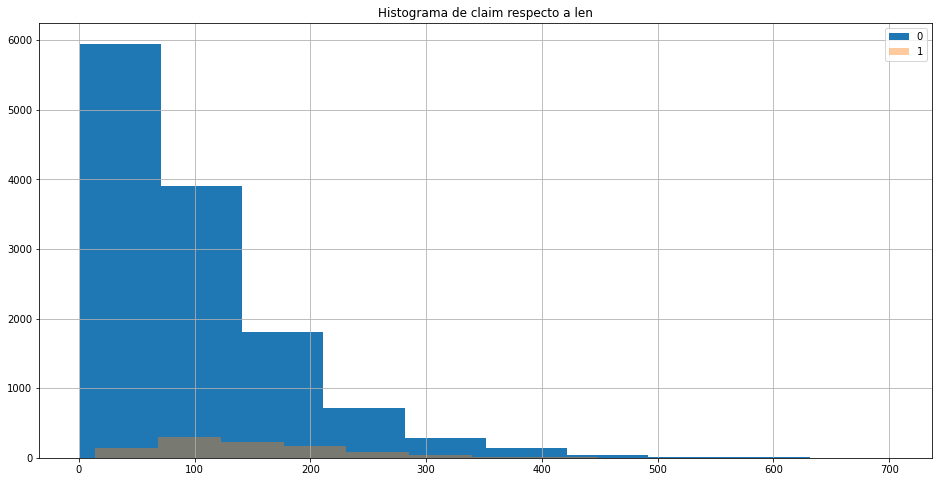

In [12]:
#Distribución entre el número de caracteres del texto y su target
df.loc[:, 'len'] = df['text_es'].apply(lambda x: len(x))

hist_lbl_col(df, 'claim', 'len')

In [13]:
#Podemos confirmar que existe una desviación en las medias de forma que a mayor número de caracteres mayor probabilidad de ser claim (con tabulate se vería mejor)
print(
    '\t', 'promedio nº caracteres', '\t', 'desviación estandar', '\n'
    'claim   ', '\t', np.mean(df[df['claim'] == 1]['len']), '\t', np.std(df[df['claim'] == 1]['len']), '\n'
    'no-claim', '\t', np.mean(df[df['claim'] == 0]['len']), '\t', np.std(df[df['claim'] == 0]['len'])
)

	 promedio nº caracteres 	 desviación estandar 
claim    	 152.41507537688443 	 84.89671865307659 
no-claim 	 100.24186154921918 	 81.40682081434487


In [14]:
#A tenor de que las no-claim tienen una mayor tendencia a emplear menos caracteres vamos a eliminar aquellas que tengan menos de dos espacios
df = df[df['text_es'].str.count('\s') >= 2]

#####Entidades

In [15]:
#Es bastante lento. El propósito es marcar aquellas utterances que contengan una entidad
%%time
df.loc[:, ['entidad', 'lista_entidades']] = list(df['text_es'].apply(lambda x: decorated_extract_entity_es(x)))

In [20]:
#Salvamos resultados intermedios
df.to_csv('df.tsv', sep='\u0001', index=False)
#df = pd.read_csv('df.tsv', sep='\u0001')

In [22]:
#Comprobamos mediante reglas de asociación la fuerza de la relación entre la aparición de entidades y el ser claim
#Puesto que es una relación débil no procede hacer nada más
cm = pd.crosstab(df['claim'], df['entidad'])
cramers_corrected_stat(cm)

0.14752434203268125

##2 - Modelado baseline

In [57]:
#Descarga modelo multi 12 layers, 768 hidden y 
!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip

--2021-04-15 18:32:06--  https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.204.128, 64.233.188.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662903077 (632M) [application/zip]
Saving to: ‘multi_cased_L-12_H-768_A-12.zip’

multi_cased_L-12_H- 100%[===================>] 632.19M  34.1MB/s    in 19s     

2021-04-15 18:32:26 (34.1 MB/s) - ‘multi_cased_L-12_H-768_A-12.zip’ saved [662903077/662903077]



In [60]:
!unzip multi_cased_L-12_H-768_A-12.zip

Archive:  modelo/multi_cased_L-12_H-768_A-12.zip
   creating: multi_cased_L-12_H-768_A-12/
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: multi_cased_L-12_H-768_A-12/vocab.txt  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: multi_cased_L-12_H-768_A-12/bert_config.json  


In [78]:
bert_ckpt_file = os.path.join(os.getcwd(), 'multi_cased_L-12_H-768_A-12', "bert_model.ckpt")
bert_config_file = os.path.join(os.getcwd(), 'multi_cased_L-12_H-768_A-12',"bert_config.json")

In [88]:
#tokenization
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))
max_seq_len = 150 #número arbitrario

from tqdm import tqdm

x, y = [], []

with tqdm(total=df.shape[0], unit_scale=True) as pbar:
    for ndx, row in df.iterrows():
        text, label = row['text_es'], row['claim']
        tokens = tokenizer.tokenize(text)
        tokens = ["[CLS]"] + tokens + ["[SEP]"]
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        max_seq_len = max(max_seq_len, len(token_ids)) #peligroso, no os parece?
        x.append(token_ids)
        y.append(int(label))
        pbar.update()

100%|██████████| 13.4k/13.4k [00:09<00:00, 1.47kit/s]


In [89]:
#casteamos a array para que no de problemas
x = np.array(x)
y = np.array(y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [90]:
#confirmando que tokeniza correctamente el español
tokenizer.tokenize('Eta fue una banda terrorista')

['eta', 'fu', '##e', 'una', 'banda', 'terrorist', '##a']

In [93]:
#padding por la derecha
x_, t = [], []
token_type_ids = [0] * max_seq_len

for input_ids in x:
    input_ids = input_ids[:min(len(input_ids), max_seq_len - 2)]
    input_ids = input_ids + [0] * (max_seq_len - len(input_ids))
    x_.append(np.array(input_ids))
    t.append(token_type_ids)

x_ = np.array(x_)
t = np.array(t)

In [138]:
#creamos el modelo

CD = ClaimDetection(bert_config_file, 
                       bert_ckpt_file, 
                       max_seq_len)

CD.model.summary()

Done loading 196 BERT weights from: /content/drive/MyDrive/newtral/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f9e196862d0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 224)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 224, 768)      

In [97]:
#Split de los datos
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

x_train, x_test, y_train, y_test = train_test_split(x_, y, test_size=1 - train_ratio)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

In [98]:
#training(más de 1h)

CD.train(x_train, y_train,
         x_val, y_val,
         'log',
         max_epoch=10,
         patience=1)

***** Model output directory: /bert_news *****
Epoch 1/10
630/630 [==============================] - 1460s 2s/step - loss: 0.3185 - acc: 0.9124 - val_loss: 0.2385 - val_acc: 0.9295
Epoch 2/10
630/630 [==============================] - 1435s 2s/step - loss: 0.2516 - acc: 0.9288 - val_loss: 0.2139 - val_acc: 0.9300
Epoch 3/10
630/630 [==============================] - 1444s 2s/step - loss: 0.2352 - acc: 0.9206 - val_loss: 0.2348 - val_acc: 0.9171


In [100]:
CD.model.save_weights('claim_detection.h5', overwrite=True)

##3 - Métricas

In [101]:
_, train_acc = CD.model.evaluate(x_train, y_train)
_, val_acc = CD.model.evaluate(x_val, y_val)
_, test_acc = CD.model.evaluate(x_test, y_test)

print("train acc: ", train_acc)
print("validation acc: ", val_acc)
print("test acc: ", test_acc)

42/42 [==============================] - 42s 935ms/step - loss: 0.2147 - acc: 0.9263
train acc:  0.9277347922325134
validation acc:  0.9299900531768799
test acc:  0.9263392686843872


In [131]:
#Dado que el accuracy no es una métrica muy precisa con clases desbalanceadas pintamos la matriz de confusión de test
#Como puede comprobarse los resultados son pésimos, la red aprende que la mejor estrategia para maximizar acc es predecir 0

predictions = CD.model.predict(x_test)
p_ = [np.argmax(i) for i in predictions]

confusion_matrix(y_test, p_)

array([[1242,    0],
       [  99,    3]])